# *Libraries*

In [1]:
import csv
import cv2
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
import os
import random



2025-04-30 01:16:33.506338: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 01:16:33.514347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745964993.523694 4172255 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745964993.526433 4172255 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-30 01:16:33.536288: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Details:", tf.config.list_physical_devices('GPU'))

Num GPUs Available: 1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **Data Insights & Splitting**

In [ ]:
datapath = 'fer2013plus/fer2013/'
trainpath = os.path.join(datapath, 'train')
testpath = os.path.join(datapath, 'test')
existingEmotions = ['0', '1', '2', '3', '4', '5']
emotionMapping = {'0': 'Anger','1': 'Fear','2': 'Happiness', '3': 'Sadness', '4': 'Disgust', '5': 'Neutral'}
num_classes = len(existingEmotions)

randemotion = random.choice(existingEmotions)
randompath = os.path.join(trainpath,randemotion)
randomimages = os.listdir(randompath)
randomindex = random.randint(0, len(randomimages)-1)

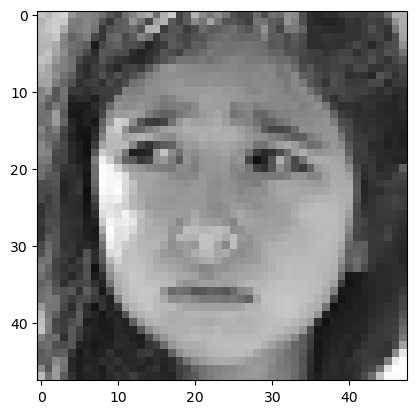

Image shape: (48, 48, 3)
This emotion is:  Sadness


In [ ]:
image = cv2.imread(os.path.join(randompath,randomimages[randomindex]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
print('Image shape:', image.shape)
print("This emotion is: ", emotionMapping[randemotion])

In [ ]:
TrainData = []
TestData = []

TrainData = ImageDataGenerator(rescale=1/255., 
zoom_range = 0.1,shear_range = 0.1,rotation_range = 10,
width_shift_range = 0.1,height_shift_range = 0.1,
horizontal_flip = True, fill_mode = 'nearest')

TestData = ImageDataGenerator(rescale=1/255.)

In [8]:
TrainData = TrainData.flow_from_directory(trainpath, target_size=(48,48), color_mode='grayscale', batch_size=32, class_mode='categorical', shuffle=True)
TestData = TestData.flow_from_directory(testpath, target_size=(48,48), color_mode='grayscale', batch_size=32, class_mode='categorical')


Found 84855 images belonging to 6 classes.
Found 15881 images belonging to 6 classes.


In [9]:
print(TrainData.class_indices)


{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}


# **Model**

### **This is the followed architecture (acheived 83.7% Val Accuracy)**
<img src="FER.png" width="1200">


In [ ]:
inputs = tf.keras.Input(shape=(48, 48, 1))

x = Conv2D(64, kernel_size=(5,5), activation='elu', padding='same', kernel_initializer = 'he_normal')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2D(64, kernel_size=(5,5), activation='elu', padding='same', kernel_initializer = 'he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, kernel_size=(5,5), activation='elu', padding='same', kernel_initializer = 'he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2D(128, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer = 'he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(256,kernel_size=(3,3), activation='elu', padding='same', kernel_initializer = 'he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(256,kernel_size=(3,3), activation='elu', padding='same', kernel_initializer = 'he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

x = Conv2D(512,kernel_size=(3,3), activation='elu', padding='same', kernel_initializer = 'he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(512,kernel_size=(3,3), activation='elu', padding='same', kernel_initializer = 'he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lr_scheduler = LearningRateScheduler(lambda epoch: 0.004 * 0.9 ** epoch)

In [ ]:
hist = model.fit(TrainData, validation_data=TestData, epochs=200, verbose=1,callbacks=[early_stopping, lr_scheduler])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


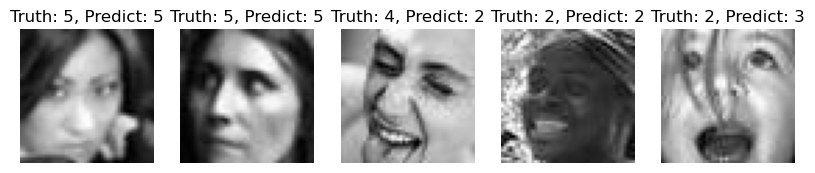

In [30]:
imgs, labels = next(TestData)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
for i in range(5):
    image = np.expand_dims(imgs[i], axis=0)
    predict = model.predict(image)[0].argmax()
    label = np.argmax(labels[i], axis=0)
    
    axes[i].imshow(imgs[i], cmap='gray')
    axes[i].set_title(f'Truth: {label}, Predict: {predict}')
    axes[i].axis('off')

plt.show()

In [ ]:

model.save('FER2013.keras')

In [ ]:
model = keras.models.load_model('FER2013.keras')
model.evaluate(TestData)

/home/group02-f24/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8377 - loss: 0.4501


[0.4556421637535095, 0.8391035199165344]

In [ ]:
emotionMapping = {0: 'Anger', 1: 'Fear', 2: 'Happiness', 3: 'Sadness', 4: 'Disgust', 5: 'Neutral'}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


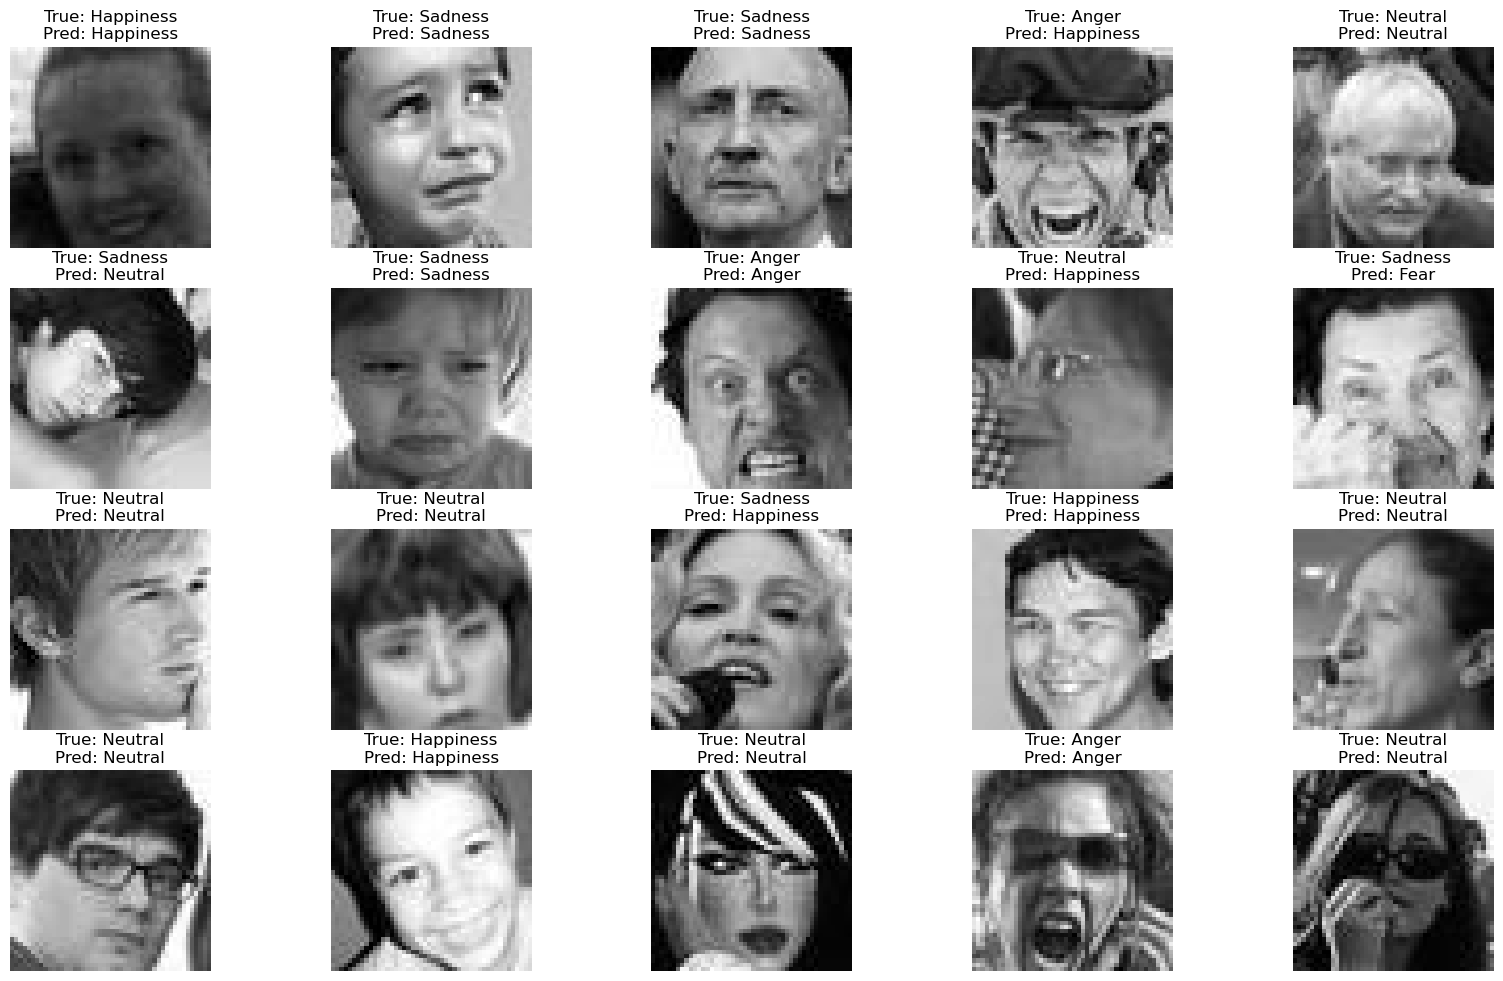

In [33]:
batch_images, batch_labels = next(TestData)
ypred = model.predict(batch_images)
ypred = np.argmax(ypred, axis=1)
batch_labels = np.argmax(batch_labels, axis=1)
batch_labels = [emotionMapping[(i)] for i in batch_labels]
ypred = [emotionMapping[(i)] for i in ypred]  # ✅ Correct
plt.figure(figsize=(20, 12))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(batch_images[i],cmap='gray')  # Already rescaled to [0,1]
    plt.title(f"True: {batch_labels[i]}\nPred: {ypred[i]}")
    plt.axis("off")
plt.show()